#  Variational auto encoder
This notebook demonstrates a simple variational auto encoder. One should read the notebook on the simple auto encoder first.

## First I define some utility functions (unchaged from the auto encoder)
This functions can mostly be ignored and are included simply from necessity

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import typing
import utils

In [2]:
def visualize_model(encoder, decoder, X_val):
    val_size = X_val.shape[0]
    j = np.random.randint(0,val_size - 5)
    z = encode.forward(X_val)
    y = decode.forward(z)
    for i in range(0,5):
        plt.subplot(1,2,1)
        plt.imshow(X_val[j + i,1:].reshape(28,28), cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(y[j + i,1:].reshape(28,28), cmap="gray")
        plt.show()

In [3]:
def calculate_loss_l2(x, y):
    loss = np.sum(0.5*(x-y)**2)
    print(f"Validation l2 loss: {loss}")
    return loss

In [4]:
def calculate_KL_loss(mean, std):
    print(f"Mean: {np.mean(mean)}, std: {np.mean(std)}")
    KL_loss = 0.5*np.sum(mean**2 + std**2 - 1 - np.log(std+1e-4))
    print(f"Validation KL loss: {KL_loss}")
    return KL_loss

In [5]:
def pre_process_images(X: np.ndarray, mean: float = 33.3, std: float = 78.5):
    """
    Args:
        X: images of shape [batch size, 784] in the range (0, 255)
    Returns:
        X: images of shape [batch size, 785]
    """
    
    X = (X-mean)/std
    
    assert X.shape[1] == 784,\
        f"X.shape[1]: {X.shape[1]}, should be 784"
    
    newArr = np.ones((X.shape[0],785))
    newArr[:,1:] = X
    assert newArr.shape == (X.shape[0], 785),\
        f"Pre processed shape: {newArr.shape}"
    return newArr


## Model definitions
Here I define an encoder and a decoder. As they are both more or less identical FCNN I define a parent class and let both modules inherit from that class. 

### Base model

In [6]:
class Model:

    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,
                 use_improved_weight_init: bool  
                 ):
        # Define number of input nodes
        self.I = neurons_per_layer[0]
        self.use_improved_sigmoid = use_improved_sigmoid
        print(f"\n\nInitializing with improved sigmoid: {use_improved_sigmoid}")
        print(f"Initializing with improved weight init: {use_improved_weight_init}")

        self.neurons_per_layer = neurons_per_layer[1:]
        
        # Initialize the weights
        self.ws = []
        prev = self.I
        for size in self.neurons_per_layer:
            w_shape = (prev, size)
            print("Initializing weight to shape:", w_shape)
            if(use_improved_weight_init):
                w = np.random.normal(0, 1/np.sqrt(prev), w_shape)
            else:
                w = np.random.uniform(-1, 1, w_shape)
            self.ws.append(w)
            prev = size
        self.grads = [None for i in range(len(self.ws))]
        #Needed for backpropagation
        self.intermediates = []
        #Needed for improved sigmoid backpropagation
        self.z = []

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Args:
            X: images of shape [batch size, 785]
        Returns:
            y: output of model with shape [batch size, num_outputs]
        """

        assert X.shape[1] == self.ws[0].shape[0], \
            f"X shape: {X.shape}, weight shape: {self.ws[0].shape}"
        self.intermediates = []
        self.z = []
        self.intermediates.append(X)
        #Functionality for multiple layers for task 4c
        for i in range(0, len(self.ws)-1):
            self.z.append(self.intermediates[-1] @ self.ws[i])
            if(self.use_improved_sigmoid):
                self.intermediates.append(1.7159*np.tanh(2*self.z[-1]/3))
            else:
                self.intermediates.append(1/(1 + np.exp(- self.z[-1])))
        
        z2 = self.intermediates[-1] @ self.ws[-1] 
        #exponent = np.exp(z2)
        #exponent /= exponent.sum(axis = 1, keepdims = True)        
        #assert exponent.shape == (X.shape[0],10),\
         #   f"Shape after forward pass is wrong"
        return z2

    def backward(self, X: np.ndarray, delta):
        """
        Args:
            X: images of shape [batch size, 785]
            outputs: outputs of model of shape: [batch size, num_outputs]
            targets: labels/targets of each image of shape: [batch size, num_classes]
        """
        batchSize = X.shape[0]
        self.grads = []
        outputGrad = self.intermediates[-1].transpose() @ delta / batchSize
        self.grads.append(outputGrad)
        
        #Generalization to multiple layers
        for i in range(1,len(self.ws)):
            Q = delta @ self.ws[-i].transpose()
            if(self.use_improved_sigmoid):
                sigmoidDerivative = 2.28786/(np.cosh(4*self.z[-i]/3) + 1)
            else:
                sigmoidDerivative = (self.intermediates[-i]*(1-self.intermediates[-i]))
            delta = sigmoidDerivative * Q
            
            hiddenGrad = self.intermediates[-i-1].transpose() @ delta / batchSize
            self.grads.append(hiddenGrad)
            
        self.grads.reverse()
        Q = delta @ self.ws[0].transpose()   
        for grad, w in zip(self.grads, self.ws):
            assert grad.shape == w.shape,\
                f"Expected the same shape. Grad shape: {grad.shape}, w: {w.shape}."
        return Q

    def zero_grad(self) -> None:
        self.grads = [None for i in range(len(self.ws))]
        
    def update_weights(self, lr):
        for w, grad in zip(self.ws, self.grads):
            w -= lr*grad


### Decode model

The decode module is exactly the same as in the Auto-encoder.

In [7]:
class DecodeModel(Model):

    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,  # Task 3a hyperparameter
                 use_improved_weight_init: bool  # Task 3c hyperparameter
                 ):
        super().__init__(neurons_per_layer, use_improved_sigmoid, use_improved_weight_init)
    def backward(self, X: np.ndarray, outputs):
        """
        Args:
            X: images of shape [batch size, 785]
            outputs: Reconstructed images of shape [batch size, 785]
        """
        batchSize = X.shape[0]
        assert X.shape == outputs.shape,\
            f"Output shape: {outputs.shape}, targets: {X.shape}"
        # A list of gradients.
        # For example, self.grads[0] will be the gradient for the first hidden layer
        self.grads = []
        delta = (outputs - X)
        return super().backward(X, delta)

### Encode model

It is here in the encode module the difference between a VAE and an AE is evident. First of all, instead of predicting a latent space vector $\vec{z}$ directly, the module predicts a vector for the mean $\vec{\mu}$ and the standard deviation $\vec{\sigma}$.

With these two parameters one can calculate the latent space vector $\vec{z}$ by sampeling a stochastic variable $\epsilon$ from the standard normal distribution. The resulting latent space vector is thus calculated as follows $z = \mu + \sigma \epsilon$ 

In order for the model to follow a more or less normal distribution, a KL loss is introduced with a standard normal distribution as prior.
$$KL = \frac{1}{2} \sum{\sigma_i^2 + \mu_i^2 -1 - \log{\sigma}}$$


This would give the derivatives:

$$\frac{dC}{d \sigma_i} = \sigma_i - \frac{1}{2 \sigma_i}$$

and

$$\frac{dC}{d \mu_i} =  \mu_i$$


As the standard deviation must be positive, I use ReLU as activation function.

In [8]:
class EncodeModel(Model):
    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,  # Task 3a hyperparameter
                 use_improved_weight_init: bool  # Task 3c hyperparameter
                 ):
        super().__init__(neurons_per_layer[:-1], use_improved_sigmoid, use_improved_weight_init)
        prev = neurons_per_layer[-2]
        w_shape = (prev, neurons_per_layer[-1])
        self.output_size = neurons_per_layer[-1]
        if(use_improved_weight_init):
            print(f"Initializing weights with shape: {w_shape}")
            self.mean_w = np.random.normal(0, 1/np.sqrt(prev), w_shape)
            self.std_w = np.random.normal(0, 1/np.sqrt(prev), w_shape)
        else:
            self.mean_w = np.random.uniform(-1, 1, w_shape)
            self.std_w = np.random.uniform(-1, 1, w_shape)
    def forward(self, X):
        x = super().forward(X)
        self.intermediate_x = (1/(1 + np.exp(- x)))
        
        self.mean = self.intermediate_x @ self.mean_w
        self.std = self.intermediate_x @ self.std_w
        
        #Activation function
        self.std = np.maximum(0,self.std)
        #self.mean = 1/(1 + np.exp(-mean))
                 
        
        self.epsilon = np.random.normal(0,1, (self.output_size))
        
        return self.mean + self.std*self.epsilon
    def backward(self, X: np.ndarray, dZ: np.ndarray):
        dKL_dSTD = self.std - 1/(2*self.std + 1e-4)
        dKL_dMean = self.mean
        batch_size = X.shape[0]
        d_mean = dZ + dKL_dMean
        d_std = self.epsilon*dZ + dKL_dSTD
        
        #sigmoid_mean = self.mean*(1-self.mean)
        #d_mean = sigmoid_mean * d_mean
        
        #sigmoid_std = self.std*(1-self.std)
        #d_std = sigmoid_std*d_std
        d_std = np.where(self.std>0, 1,0)*d_std
        
        self.mean_w_grad = self.intermediate_x.transpose() @ d_mean / batch_size
        self.std_w_grad = self.intermediate_x.transpose() @ d_std / batch_size
        
        Q_mean = d_mean @ self.mean_w.transpose()
        Q_std = d_std @ self.std_w.transpose()
        sigmoidDerivative = self.intermediate_x*(1-self.intermediate_x)
        dX = sigmoidDerivative*(Q_mean + Q_std)
        super().backward(X, dX)
    
    def update_weights(self, lr):
        for w, grad in zip(self.ws, self.grads):
            w -= lr*grad
        self.mean_w -= lr*self.mean_w_grad
        self.std_w -= lr*self.std_w_grad


## Putting everything together for auto encoder
Here I define a training function for training on mnist data. I combine the encoder and decoder into an unsuperised auto encoder.

The encoder outputs a vector z. This is called the latent-space, and is a low dimentional mapping of x. In this example I relatively successfully reduce the 784 dimentional image into a 5 dimentional lantent space.

The 5 dimentional latent-space vector is then passed through the decoder to try to recreate the original image. 

In [9]:
def train_mnist(encoder, decoder, num_epochs):
    validation_percentage = 0.1
    X_train, Y_train, X_val, Y_val, X_test, Y_test = utils.load_full_mnist(
        validation_percentage)
    val_size = X_val.shape[0]
    print(f"Validation percentage: {validation_percentage}, gives validation size: {val_size}")
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = pre_process_images(X_train, mean, std)
    X_val = pre_process_images(X_val, mean, std)
    
    
    val_loss = {}
    
    batch_size = 16
    num_batches_per_epoch = X_train.shape[0] // batch_size
    num_steps_per_viz = num_batches_per_epoch*2
    num_steps_per_val = num_batches_per_epoch // 5
    lr = 0.01
    global_step = 0
    for epoch in range(num_epochs):
            print("\n"*3 + "Starting epoch: ", epoch)
            for step in range(num_batches_per_epoch):
                start = step * batch_size
                end = start + batch_size
                x = X_train[start:end]

                encode.zero_grad()
                decode.zero_grad()
                z  = encode.forward(x)
                y = decode.forward(z)
                delta = decode.backward(x, y)
                encode.backward(x, delta)
                encode.update_weights(lr)
                for w, grad in zip(decode.ws, decode.grads):
                    w -= lr*grad


                # Track train / validation loss / accuracy
                # every time we progress 20% through the dataset
                if (global_step % num_steps_per_viz) == 0:
                    visualize_model(encoder, decoder, X_val)
                global_step += 1
                if (global_step % num_steps_per_val) == 0:
                    z = encoder.forward(X_val)
                    y = decoder.forward(z)
                    loss = calculate_KL_loss(encoder.mean, encoder.std)
                    loss += calculate_loss_l2(X_val,y)
                    print(f"Total loss: {loss}")
                    val_loss[global_step] = loss
                    

    return val_loss



Initializing with improved sigmoid: False
Initializing with improved weight init: True
Initializing weight to shape: (785, 100)
Initializing weight to shape: (100, 50)
Initializing weights with shape: (50, 5)


Initializing with improved sigmoid: False
Initializing with improved weight init: True
Initializing weight to shape: (5, 50)
Initializing weight to shape: (50, 100)
Initializing weight to shape: (100, 785)
Train shape: X: (54000, 784), Y: (54000, 1)
Validation shape: X: (6000, 784), Y: (6000, 1)
Test shape: X: (10000, 784), Y: (10000, 1)
Validation percentage: 0.1, gives validation size: 6000



Starting epoch:  0


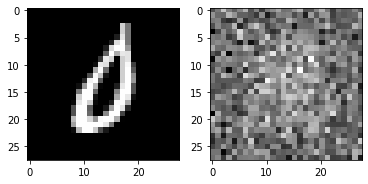

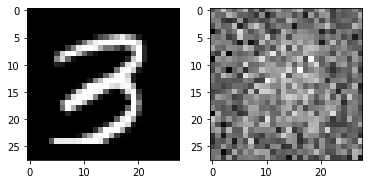

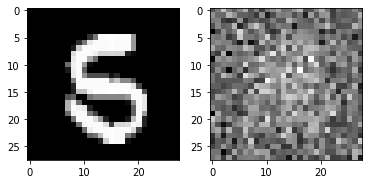

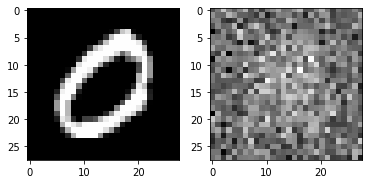

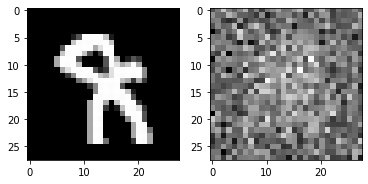

Mean: 0.005289009480369384, std: 0.25313766669081494
Validation KL loss: 59595.35352356499
Validation l2 loss: 1420674.9499862907
Total loss: 1480270.3035098556
Mean: -0.08529456898025715, std: 0.197869767475711
Validation KL loss: 42010.6080119789
Validation l2 loss: 1301901.449001042
Total loss: 1343912.0570130209
Mean: -0.025397829557755488, std: 0.22917698581439291
Validation KL loss: 22968.49926109452
Validation l2 loss: 1265327.1146388832
Total loss: 1288295.6138999776
Mean: -0.04437784074844155, std: 0.18417136156283262
Validation KL loss: 26018.18370262107
Validation l2 loss: 1168129.2277530096
Total loss: 1194147.4114556308
Mean: -0.05205749976358488, std: 0.1799750164712844
Validation KL loss: 25108.185344935133
Validation l2 loss: 1138169.9072854943
Total loss: 1163278.0926304294



Starting epoch:  1
Mean: -0.06151285990473548, std: 0.19952835366615074
Validation KL loss: 28225.287177484264
Validation l2 loss: 1105671.5587263817
Total loss: 1133896.845903866
Mean: -0.080428

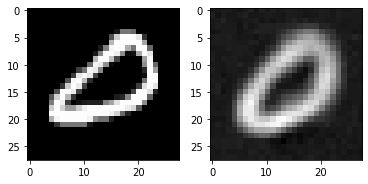

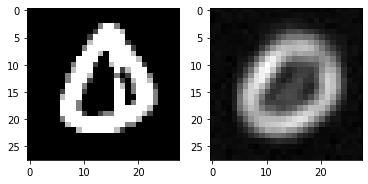

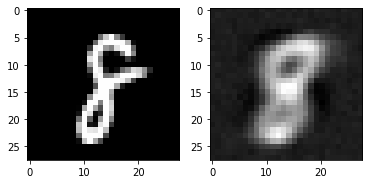

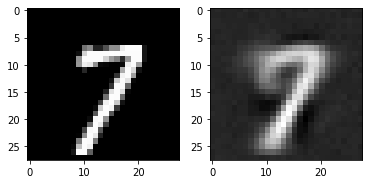

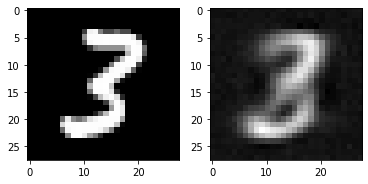

Mean: -0.03590520838490544, std: 0.1301689099968536
Validation KL loss: 33254.03835716561
Validation l2 loss: 947322.3166552269
Total loss: 980576.3550123925
Mean: -0.07750037798399965, std: 0.1377134074906421
Validation KL loss: 32645.949682204846
Validation l2 loss: 939968.3853253864
Total loss: 972614.3350075913
Mean: -0.03522439074095675, std: 0.13075594162081564
Validation KL loss: 34175.368113505865
Validation l2 loss: 923271.964338583
Total loss: 957447.332452089
Mean: -0.06710313392526074, std: 0.12134293870162856
Validation KL loss: 32752.42647906579
Validation l2 loss: 898819.978573998
Total loss: 931572.4050530638
Mean: -0.11981836601665799, std: 0.0942159250048602
Validation KL loss: 36244.84072212669
Validation l2 loss: 890920.7088660068
Total loss: 927165.5495881335



Starting epoch:  3
Mean: -0.04709481006259645, std: 0.10353331507404911
Validation KL loss: 33483.79398821475
Validation l2 loss: 878568.909568213
Total loss: 912052.7035564277
Mean: -0.019567011135432893, 

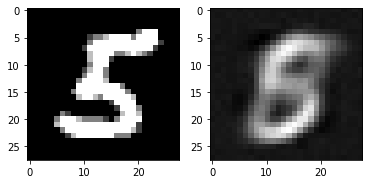

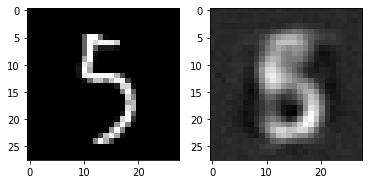

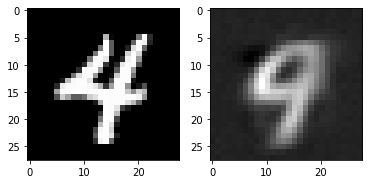

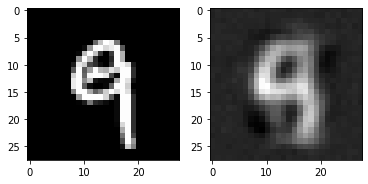

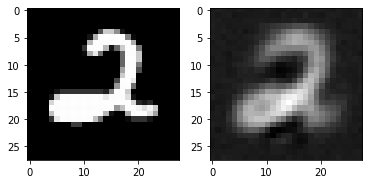

Mean: -0.04105854037361409, std: 0.07105881735064372
Validation KL loss: 41243.3065415072
Validation l2 loss: 832155.3176241844
Total loss: 873398.6241656917
Mean: -0.04262935309130279, std: 0.06780730841012078
Validation KL loss: 39636.91503438132
Validation l2 loss: 838428.4255126824
Total loss: 878065.3405470637
Mean: -0.011363688424132568, std: 0.08087535510423688
Validation KL loss: 40720.94198857681
Validation l2 loss: 840007.4144361505
Total loss: 880728.3564247272
Mean: -0.07069463231246213, std: 0.07470846059576565
Validation KL loss: 37099.02469529109
Validation l2 loss: 821848.3812266092
Total loss: 858947.4059219003
Mean: -0.06523471417360982, std: 0.07139139353194923
Validation KL loss: 38858.45665068072
Validation l2 loss: 809944.7761080936
Total loss: 848803.2327587743



Starting epoch:  5
Mean: -0.01513049854032627, std: 0.06921767861189734
Validation KL loss: 37547.26005297111
Validation l2 loss: 808406.4772886237
Total loss: 845953.7373415948
Mean: -0.009234633940039

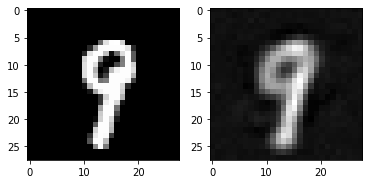

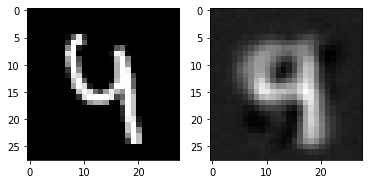

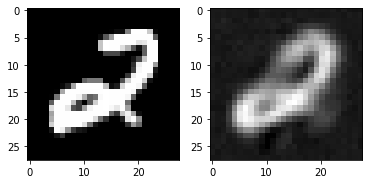

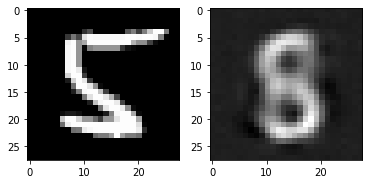

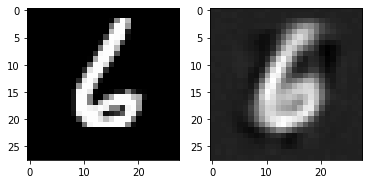

Mean: -0.05640803526862106, std: 0.06347290000960441
Validation KL loss: 38990.89145279223
Validation l2 loss: 791800.8740173582
Total loss: 830791.7654701504
Mean: -0.035927457450918084, std: 0.06517286383972537
Validation KL loss: 40127.200716885956
Validation l2 loss: 790061.8626854706
Total loss: 830189.0634023566
Mean: -0.04538632443080662, std: 0.06641909131994753
Validation KL loss: 40246.66753110031
Validation l2 loss: 784003.2776674023
Total loss: 824249.9451985026
Mean: -0.01785875738770698, std: 0.07352699770919519
Validation KL loss: 36992.35257449646
Validation l2 loss: 770658.1591178186
Total loss: 807650.511692315
Mean: -0.0014599017529868382, std: 0.07095027256272064
Validation KL loss: 37762.99636321305
Validation l2 loss: 791339.89654422
Total loss: 829102.8929074331



Starting epoch:  7
Mean: -0.0626364627763439, std: 0.060971712367344645
Validation KL loss: 39489.557385315115
Validation l2 loss: 776239.1574718499
Total loss: 815728.714857165
Mean: -0.00688069251265

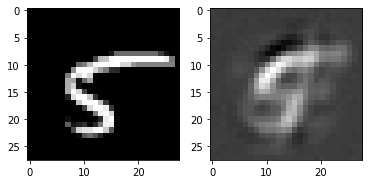

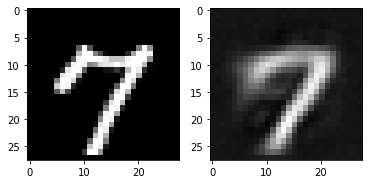

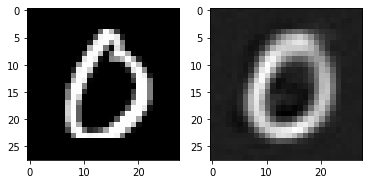

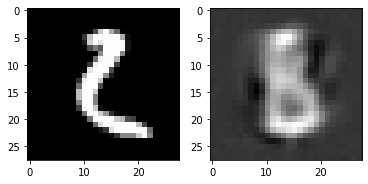

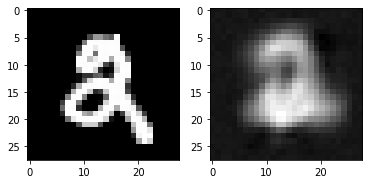

Mean: -0.003227671960230527, std: 0.0635740853516291
Validation KL loss: 38964.07779676726
Validation l2 loss: 765609.5582858643
Total loss: 804573.6360826315
Mean: -0.049703355755182144, std: 0.061076400107758416
Validation KL loss: 39682.29891599147
Validation l2 loss: 762242.0074980345
Total loss: 801924.306414026
Mean: -0.03690437943703808, std: 0.06336477934962885
Validation KL loss: 39762.841338915656
Validation l2 loss: 753996.7572284958
Total loss: 793759.5985674114
Mean: -0.012635031341799533, std: 0.06097746517411865
Validation KL loss: 39486.061463332306
Validation l2 loss: 751555.93947428
Total loss: 791042.0009376123
Mean: -0.006342745927968286, std: 0.06773012016416585
Validation KL loss: 38163.583091062756
Validation l2 loss: 759579.4441714492
Total loss: 797743.0272625119



Starting epoch:  9
Mean: -0.05285995464933657, std: 0.06356504252599397
Validation KL loss: 38153.35850142383
Validation l2 loss: 786436.6032039146
Total loss: 824589.9617053384
Mean: -0.03040865097

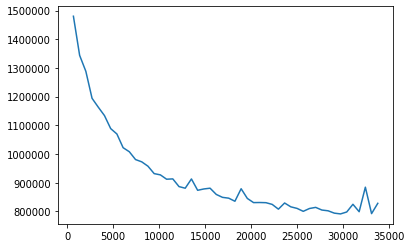

In [10]:
encode = EncodeModel([785,100,50,5], False, True)
decode = DecodeModel([5,50, 100, 785],False, True)
val_loss = train_mnist(encode, decode, 10)
utils.plot_loss(val_loss, "Validation loss")

## Sampling
Sampling is not really possible in the simple auto encoder as it is not stochastic in nature. The see the notebook on variational auto encoder instead.

In [34]:
def sampling(encoder, decoder):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = utils.load_full_mnist(0.2)
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_val = pre_process_images(X_val, mean, std)
    z = encoder.forward(X_val[1,:].reshape(1,-1))
    epsilon = np.ones(5)
    #epsilon[0] = -2.
    for i in range(0,10):
        #epsilon[0] += 0.2
        
        z = encoder.mean + epsilon*encoder.std
        y = decoder.forward(z)
        plt.imshow(y[0,1:].reshape(28,28), cmap = "gray")
        plt.show()

Train shape: X: (48000, 784), Y: (48000, 1)
Validation shape: X: (12000, 784), Y: (12000, 1)
Test shape: X: (10000, 784), Y: (10000, 1)


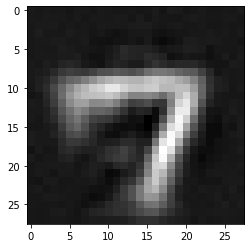

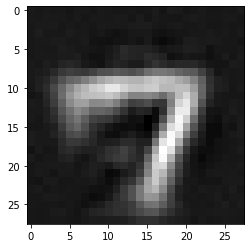

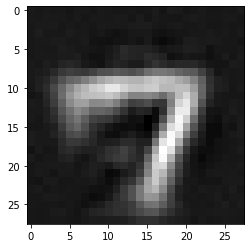

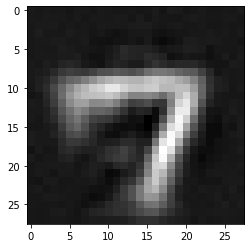

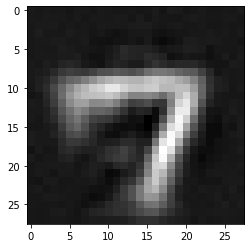

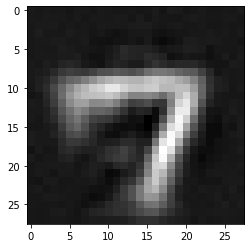

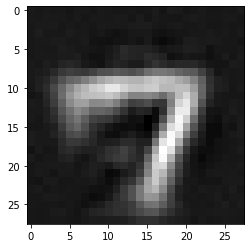

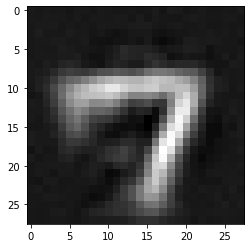

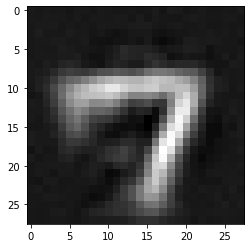

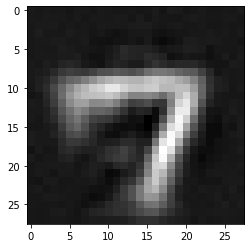

In [35]:
sampling(encode,decode)